# 10 Confusing XGBoost Hyperparameters and How to Tune Them Like a Pro in 2023
## XGBoost hyperparameters done with style and visuals
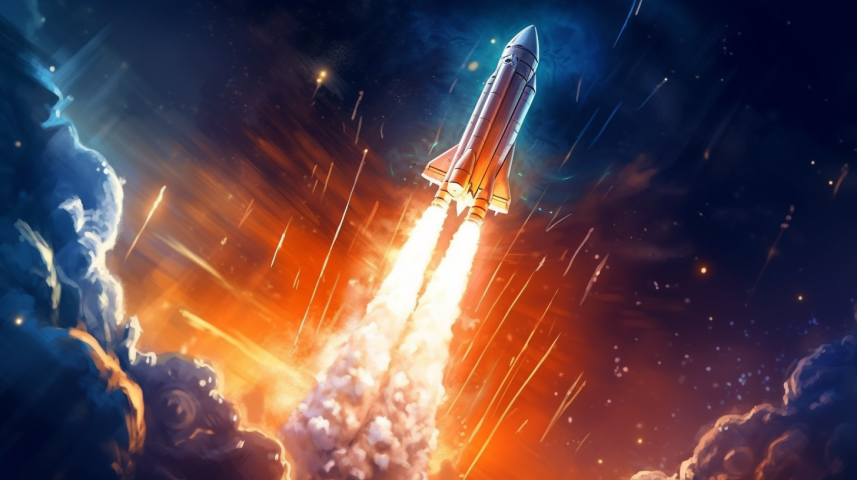

### Intro

Today, I am going to show you how to squeeze XGBoost so hard that both 'o's pop out. We will achieve this by fine-tuning its hyperparameters to such an extent that it will no longer be able to _bst_ after giving us all the performance it can.

This will not be a mere hyperparameter checklist post. Oh no. I will provide a detailed explanation of each of the ten hyperparameters, functionalities, accepted value ranges, best practices, and how to use Optuna for hyperparameter tuning.

Let's dive in!

----------------

### What we wanted all along...

A dumb underfit XGBoost model is virtually unheard of. Even with default parameter values, it performs reasonably well on many tabular tasks. However, its biggest problem lies in over-effing-fitting.

To address this issue, most of the XGBoost hyperparameters are put there to tame the underlying beast so that it doesn't just swallow up the training set and burp up the bones during testing. 

Therefore, through hyperparameter tuning, our goal is to strike the optimal balance between a complex model that overfits and a tamed, simple model that generalizes well to unseen data.

The following parameters are crucial for controlling overfitting:

- `eta`
- `num_boost_round`
- `max_depth`
- `subsample`
- `colsample_bytree`
- `gamma`
- `min_child_weight`
- `lambda`
- `alpha`

In addition to these, we will explore the tuning techniques for a couple more parameters.

----------------

### Sklearn XGBoost vs. Native XGBoost

I really struggle with these two as Sklearn is my favorite library while XGBoost is my favorite library name (it fits perfectly with `bexgboost` - domain taken).

However, when we consider objective facts, the native XGBoost training API offers a slight advantage over the Sklearn API in terms of flexibility and access to advanced and nuanced features.

I agree that the Scikit-learn API integrates seamlessly with the Sklearn ecosystem, including pipelines, cross-validators, and other functionalities. But, for the purpose of this article, we will focus on the native XGBoost API.

However, for those who are dead set on the Sklearn API, I will also provide the hyperparameter aliases specifically for that interface.

----------------

### The code to tune

In my two years of experience with XGBoost, I found that the code to tune its hyperparameters isn't nearly as difficult as understanding the theory behind each parameter and choosing appropriate tuning ranges for them.

So, before I explain how each hyperparameter works and their importance, I will leave [this GitHub Gist link](https://gist.github.com/BexTuychiev/823df08d2e3760538e9b931d38439a68) to copy/paste into your own work. The code will tune any XGBoost model with cross-validation and returns the best parameters. There is no need to share the code here as it will become very unreadable on mobile.

For those looking to understand the code and how Optuna works in tuning, I recommend this article of mine (highly _objective_ choice :)

https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c

And before I finally start explaining the parameters, I will also leave two tables you can refer to for some details you shouldn't waste time memorizing.

The first one contains the parameters' Sklearn aliases and their recommended tuning ranges:

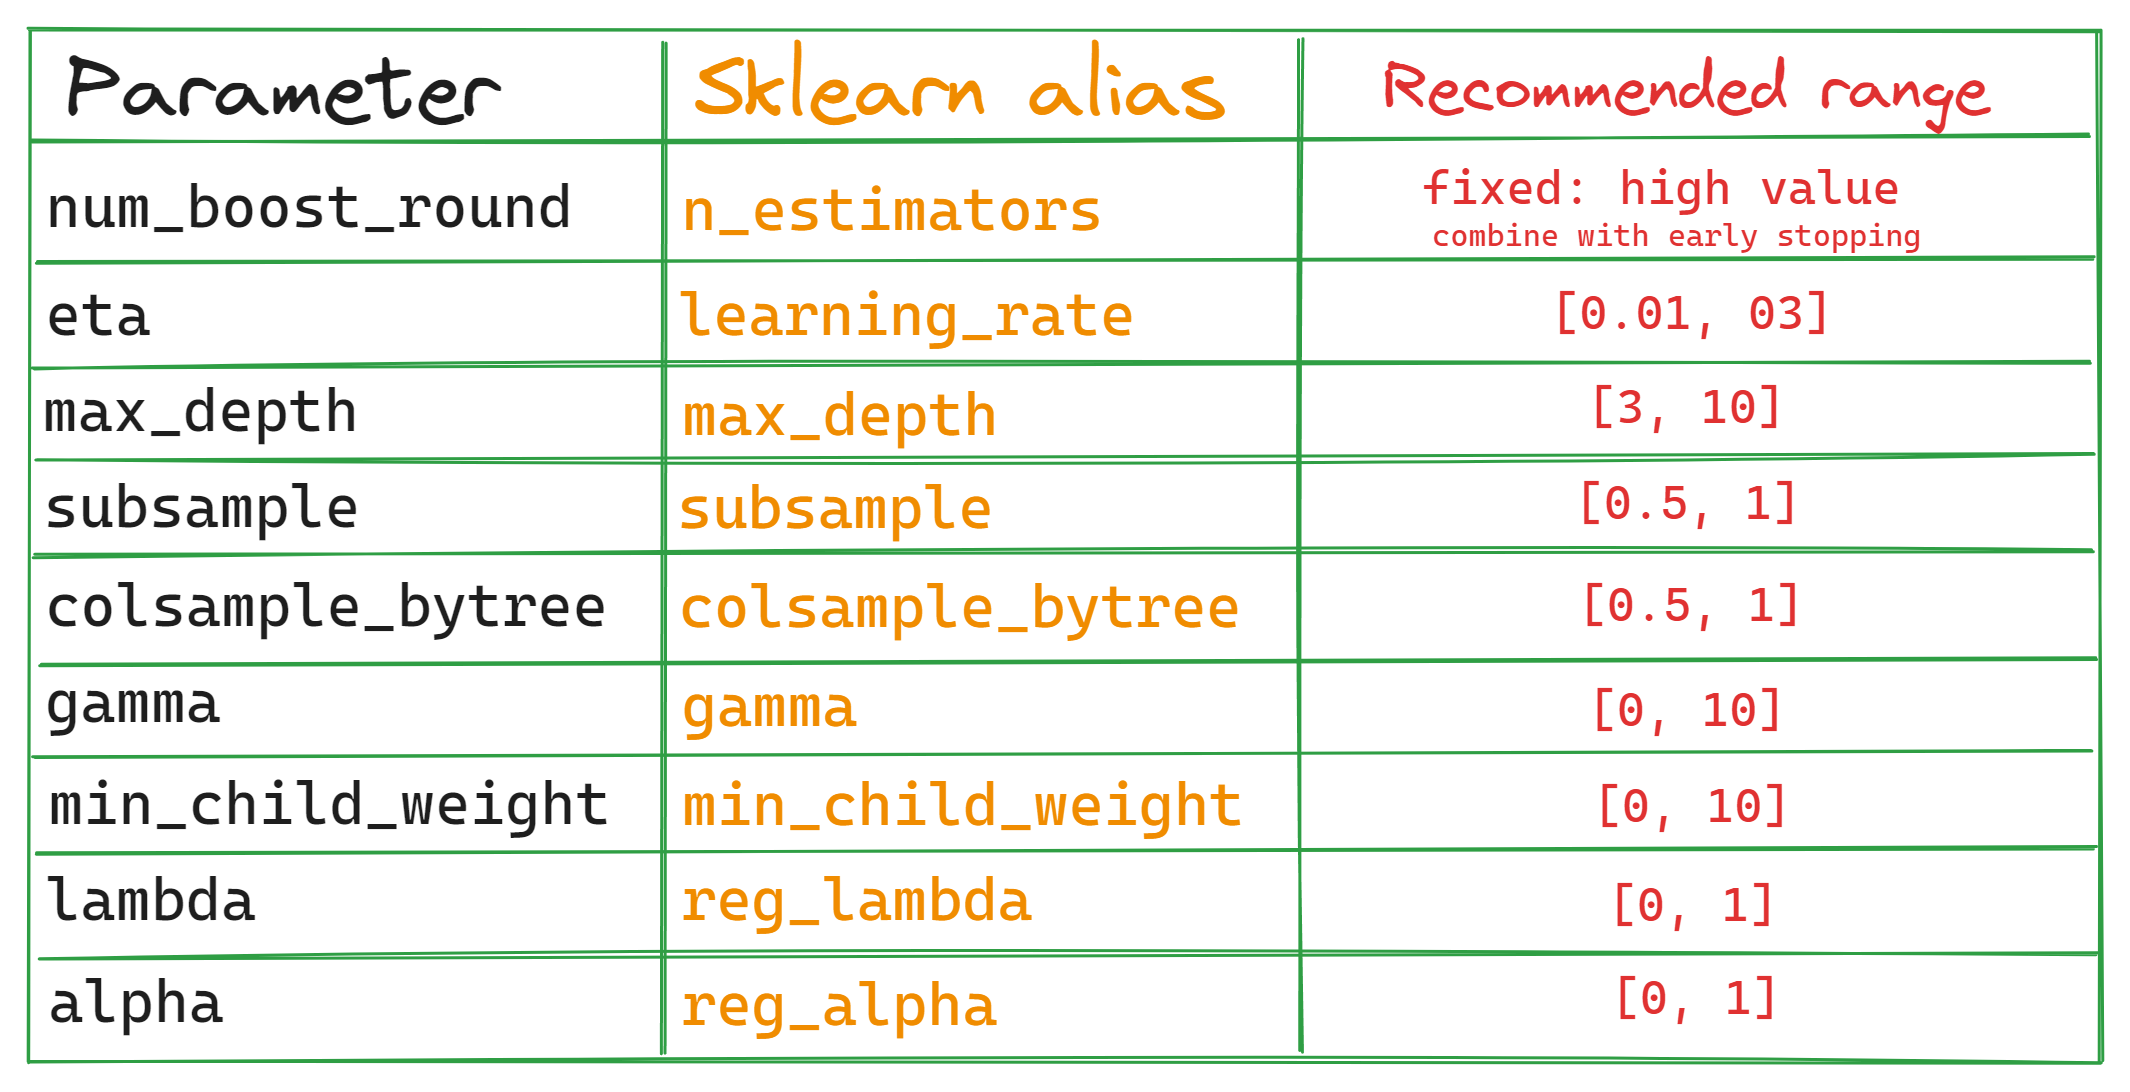

You can use the table in case you want to use a tuner other than Optuna. 

And this one is for the interplay between individual pairs of parameters:

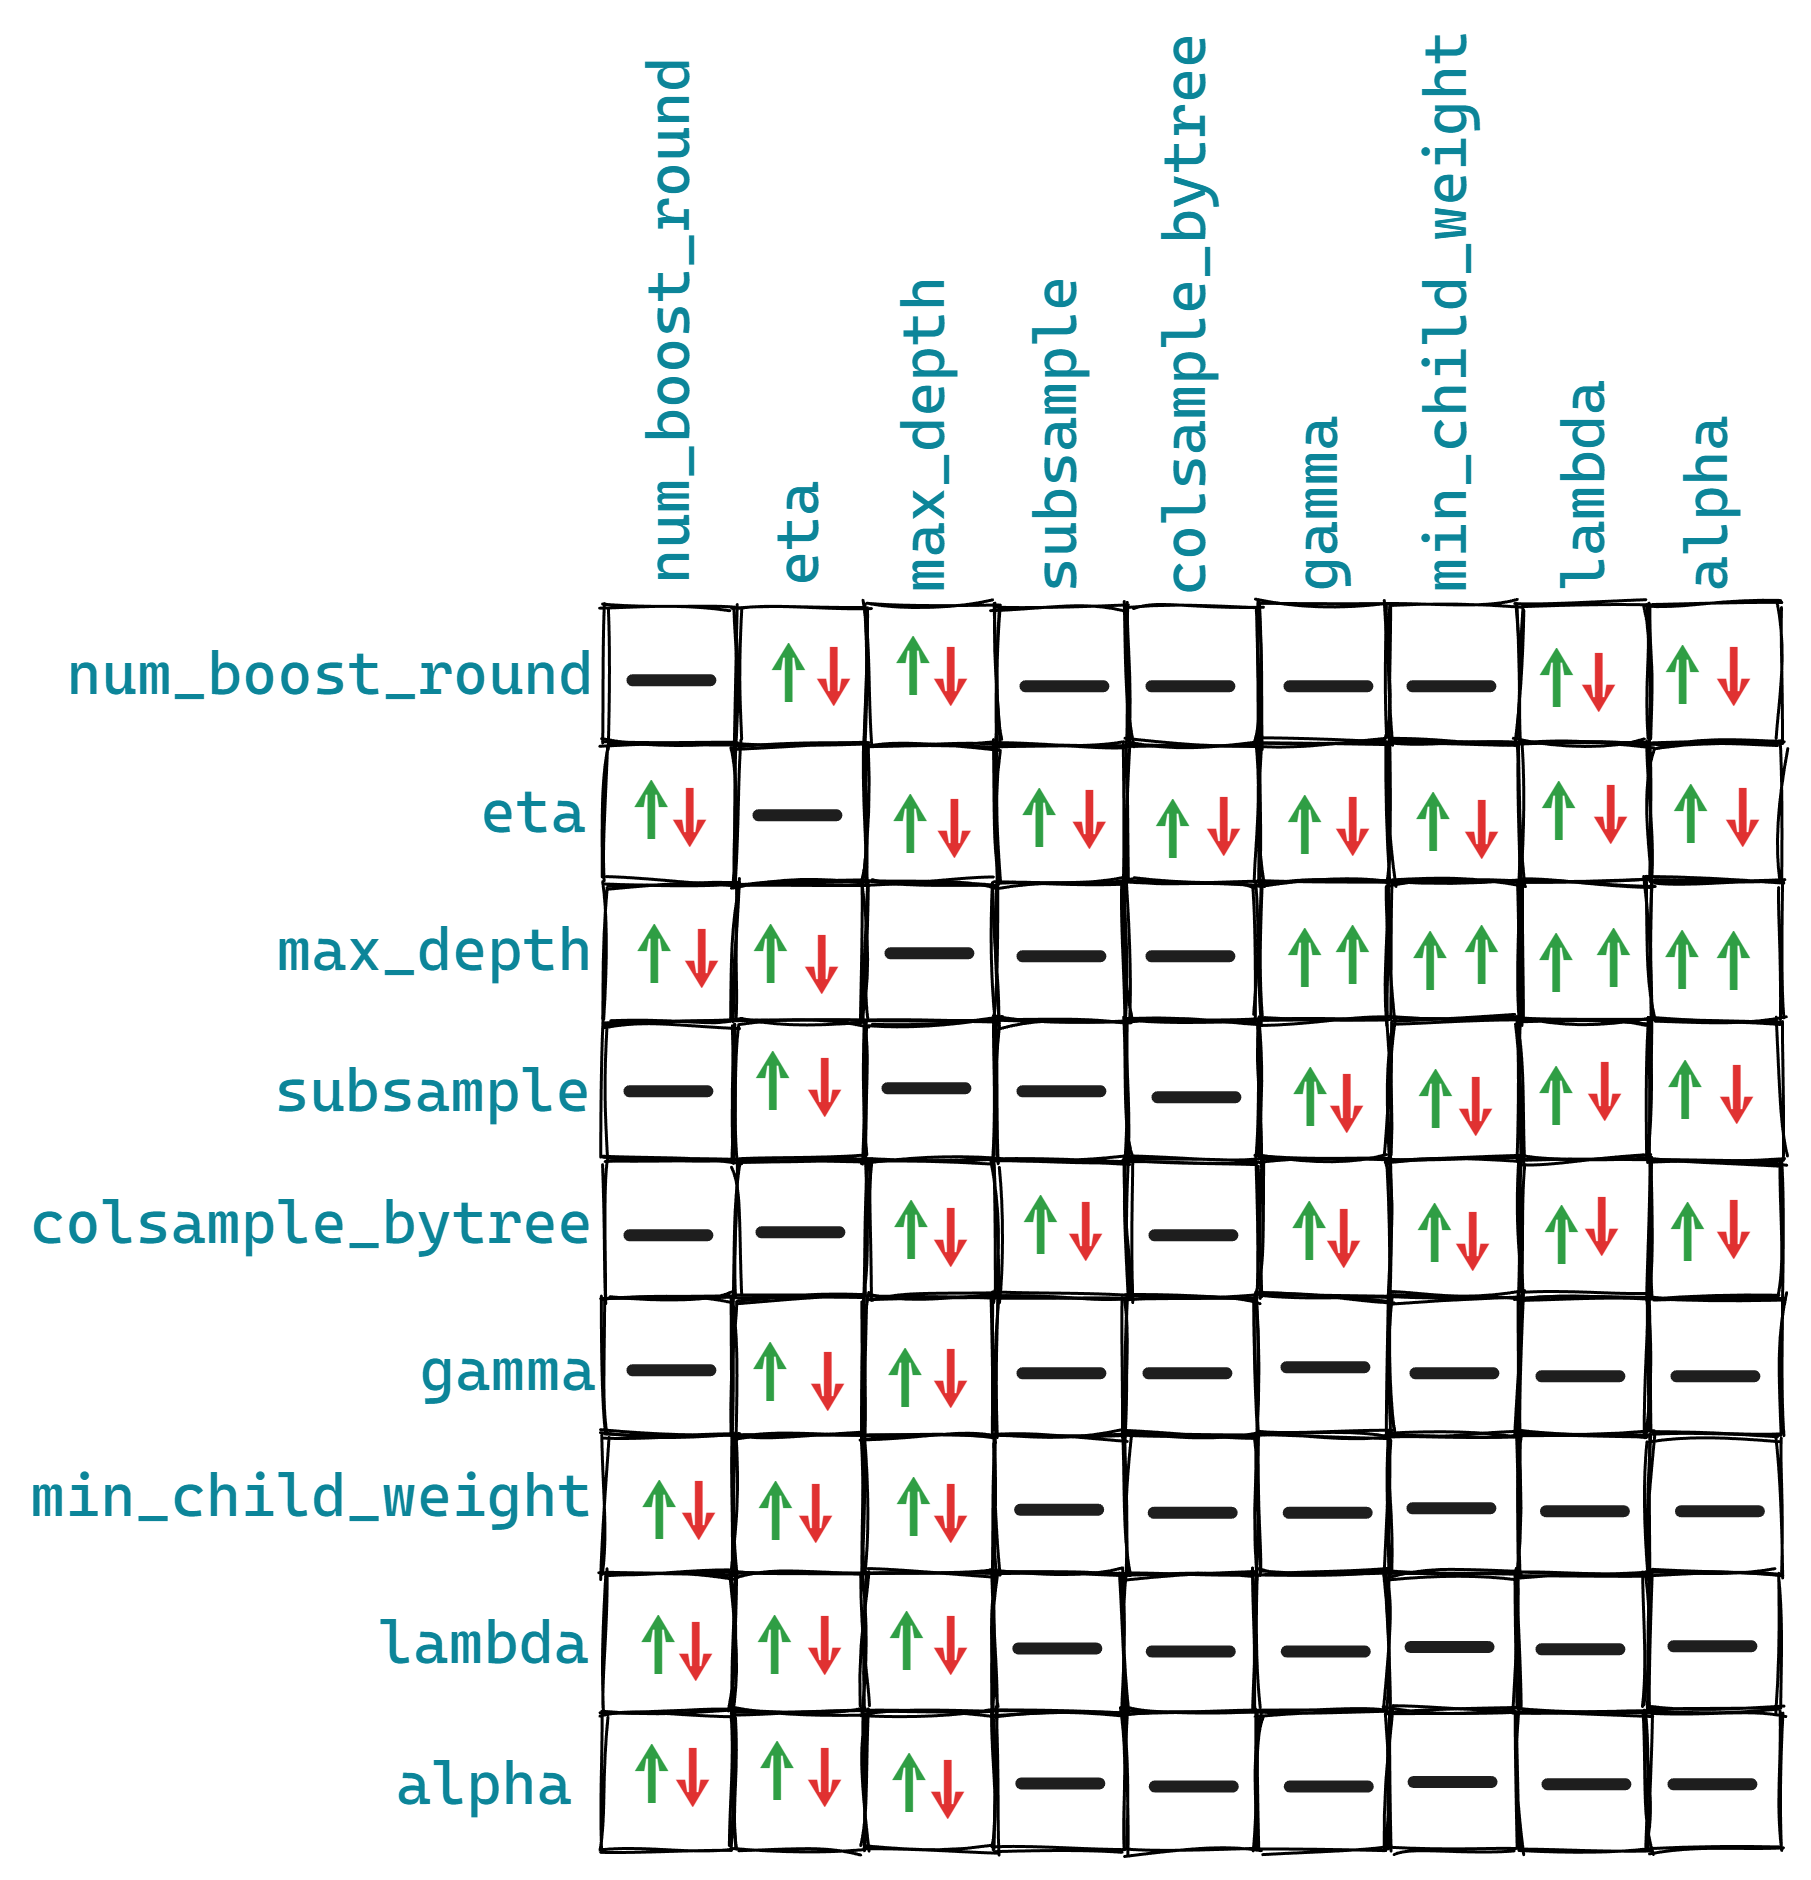

These relationships aren't set in stone and other parameters might influence them. But they can give a rough picture of what bumps with what in XGBoost. 

----------------

### The story of 10 parameters

__0. `objective` - No Sklearn alias__

First, you have to determine your path in the woods by setting an `objective` (XGBoost is tree-based, ensemble model):

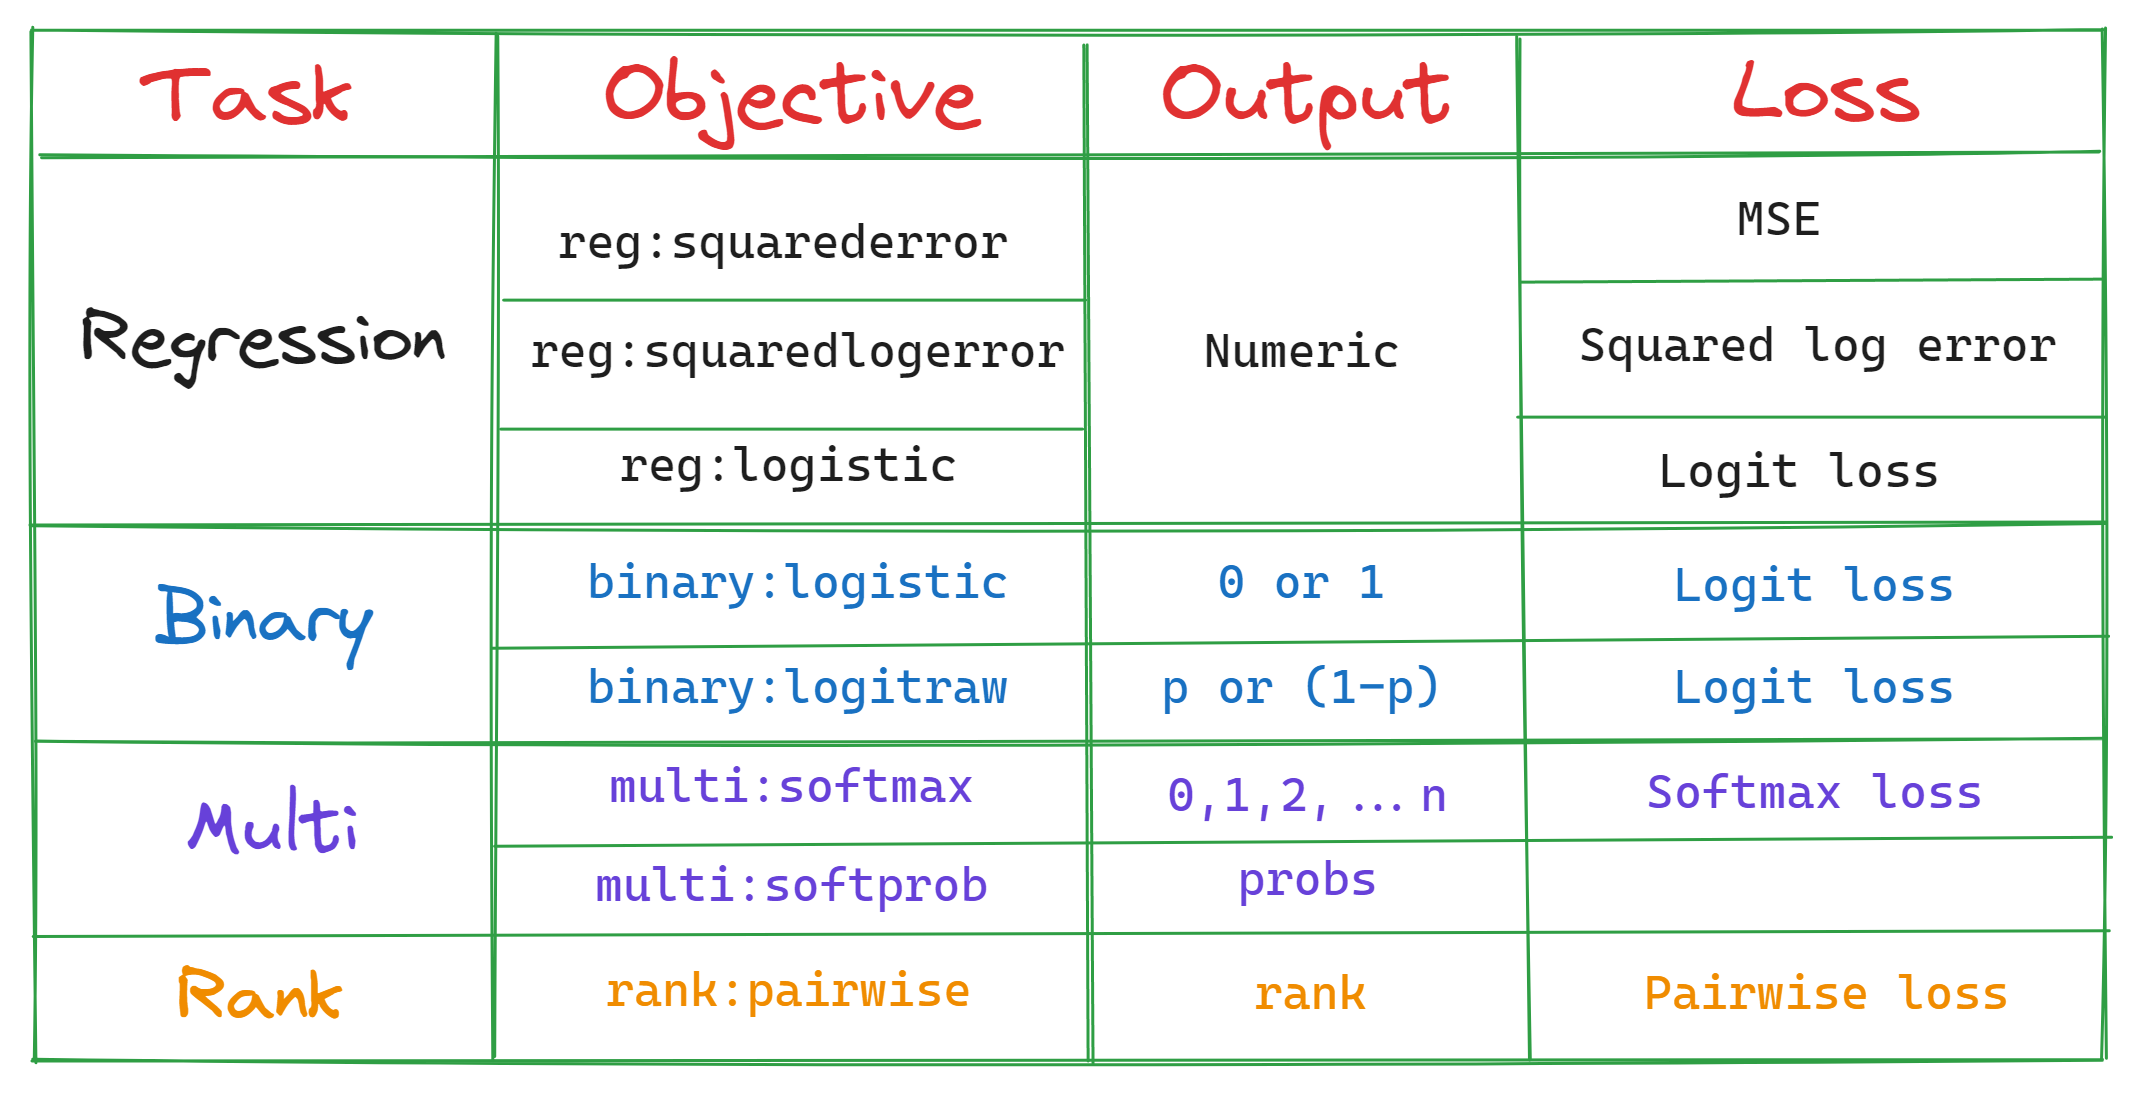

`objective` directly influences the kind of decision trees and the loss function to use. 


----------------

__1. `num_boost_round` - `n_estimators`__

Afterwards, you have to determine the number of decision trees (often called base learners in XGBoost) to plant during training using `num_boost_round`. The default is 100 but that's hardly enough for today's large datasets. 

Increasing the parameter will plant more trees but significantly increases the chances of overfitting as the model becomes more complex.

One trick I learned from Kaggle is to set a high number like 100,000 for `num_boost_round` and make use of __early stopping rounds__.

In each boosting round, XGBoost plants one more decision tree to improve the collective score of the previous ones. That's why it is called boosting. This process continues until `num_boost_round` rounds, regardless whether each new round is an improvement on the last or not. 

But by using early stopping, we can stop the training and thus planting of unnecessary trees when the score hasn't been improving for the last 5, 10, 50 or any arbitrary number of rounds.

With this trick, we can find the perfect number of decision trees without even tuning `num_boost_round` and we will save time and computation resources. Here is how it would look like in code:

```python
# Define the rest of the params
params = {...}

# Build the train/validation sets
dtrain_final = xgb.DMatrix(X_train, label=y_train)
dvalid_final = xgb.DMatrix(X_valid, label=y_valid)

bst_final = xgb.train(
    params,
    dtrain_final,
    num_boost_round=100000 # Set a high number
    evals=[(dvalid_final, "validation")],
    early_stopping_rounds=50, # Enable early stopping
    verbose_eval=False,
)
```

The above code would've made XGBoost use 100k decision trees but because of early stopping, it will stop when the validation score hasn't been improving for the last 50 rounds. Usually, the number of required trees will be less than 5000-10000.

Controlling `num_boost_round` is also one of the biggest factors in how long the training process runs as more trees require more resources.

----------------

__2. `eta` - `learning_rate`__

In each round, all existing trees return a prediction on the given input. For example, in the fifth round of boosting, the five trees may return the following predictions for sample N:

1. Tree 1: 0.57
2. Tree 2: 0.9
3. Tree 3: 4.25
4. Tree 4: 6.4
5. Tree 5: 2.1

To return a final prediction, these outputs need to be summed up but before that, XGBoost shrinks or scales them using a parameter called `eta` or learning rate. After scaling, the final output will be:

```python
output = eta * (0.57 + 0.9 + 4.25 + 6.4 + 2.1)
```

A large learning rate gives a bigger weight to the contribution of each tree in the ensemble but this may lead to overfitting/instability but faster training times. Conversely, lower learning rate dampens the contribution of each tree, making the learning process slower but more robust. 

This regularization effect of learning rate parameter is especially useful for complex and noisy datasets.

Learning rate has an inverse relationship with other parameters such as `num_boost_round`, `max_depth`, `subsample`, and `colsample_bytree`. Lower learning rate requires higher values for these parameters and vice versa. But you don't have to worry about the interplay between these parameters as the hyperparameter tuner will find the best combination.

----------------

__3, 4. `subsample` and `colsample_bytree`__

Subsampling is a form of bagging that introduces more randomness into training and hence, help combat overfitting more. 

`subsample=0.7` means that each decision tree in the ensemble will train on 70% of the available data, selected randomly. A value of 1.0 indicates that all rows will be used (no subsampling).

Similar to `subsample`, there is also `colsample_bytree`. As the name implies, `colsample_bytree` controls the fraction of features each decision tree will use. `colsample_bytree=0.8` makes each tree use the random 80% of the available features (columns) in each tree.

Adjusting these two parameters allows you to control the trade-off between bias and variance. Using smaller values reduces the correlation among the trees and increases the diversity in the ensemble, which can help improve generalization and reduce overfitting. 

However, it may also introduce more noise and increase the bias of the model. Conversely, using larger values increase the correlation among the trees, reducing the diversity and potentially leading to overfitting.

----------------

__5. `max_depth`__

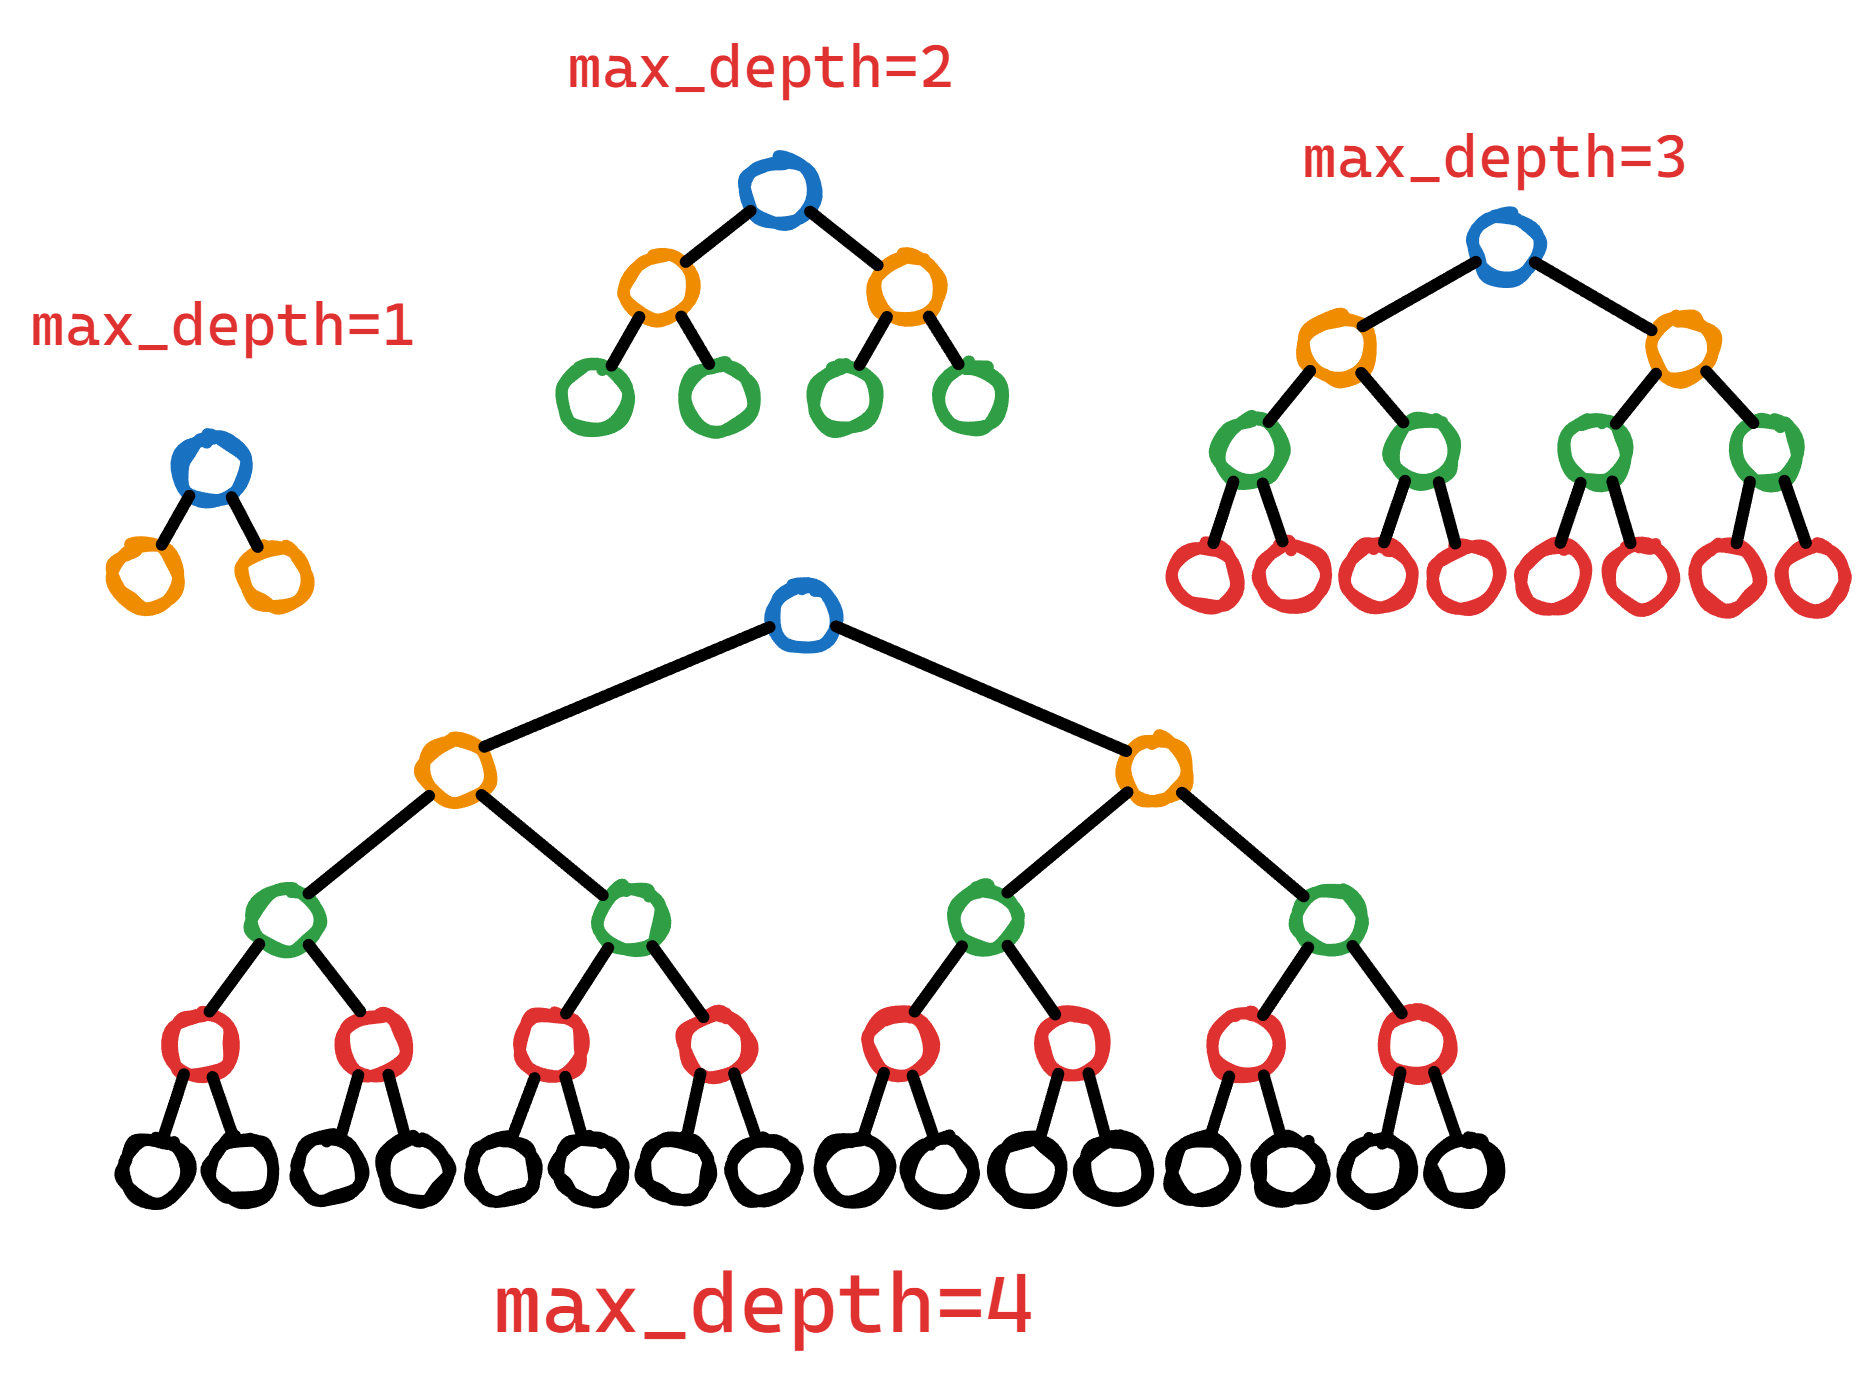

Max depth controls the maximum number of levels a decision tree may reach during training.

Deeper trees can capture more complex interactions among features. However, deeper trees also have a higher risk of overfitting, as they can memorize noise or irrelevant patterns in the training data. 

To control this complexity, `max_depth` can be limited, leading to shallower trees that are simpler, and capturing more general patterns. 

`max_depth` is a great balancer between complexity and generalization.

----------------

__6, 7. `alpha`, `lambda`__

`alpha` (L1) and `lambda` (L2) are yet two other regularization parameters to help with overfitting. 

Their difference between other regularization parameters is that they can shrink the weights of unimportant or insignificant features down to 0 (especially `alpha`), leading to a model with fewer features and thus, less complexity. 

The effect of `alpha` and `lambda` can be influenced by other parameters such as `max_depth`, `subsample`, and `colsample_bytree`. Higher values of `alpha` or `lambda` may require adjusting other parameters to compensate for the increased regularization. For example, a higher `alpha` value may benefit from a larger `subsample` value to maintain model diversity and prevent underfitting.

----------------

__8. `gamma`__

If you read XGBoost docs, it says that `gamma` is:

> the minimum loss reduction required to make a further partition on a leaf node of the tree.

I think the sentence doesn't make sense to anyone other than the person who wrote it. Let's break it down.

The following is a decision tree with two levels:

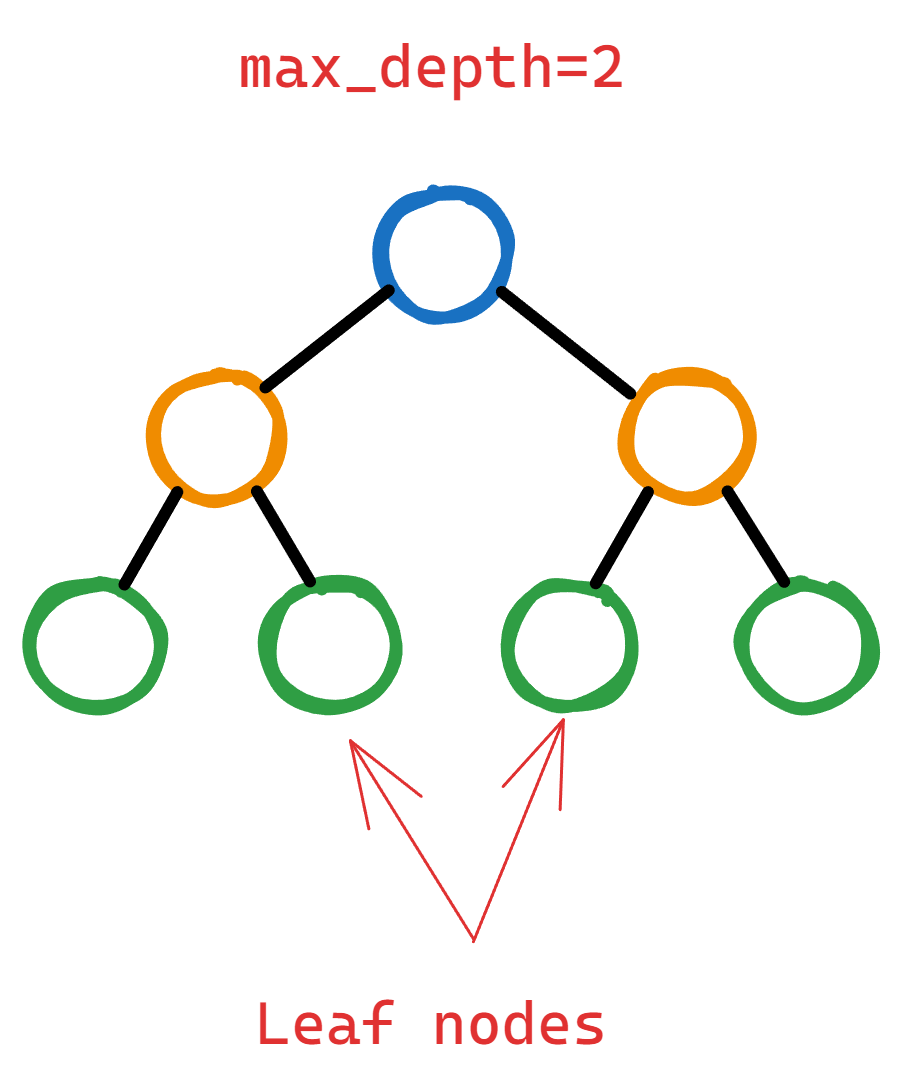

To justify adding more layers to the tree by splitting the leaf nodes, XGBoost should calculate that this operation should significantly lower the loss function. 

But 'how much significantly?' you may ask. That's where we set `gamma` - it acts as a threshold for deciding whether a leaf node should be split further.

If the reduction in loss function (often called __gain__) is less than chosen `gamma` after a potential split, then the split is not performed. This means the leaf node will remain the same and the tree won't grow from that point on. 

So, the goal from tuning `gamma` is to find the best splits that lead to the greatest reduction in the loss function, which signifies improved model performance.

----------------

__9. `min_child_weight`__

XGBoost starts the initial training process with a single decision tree with a single, root node. That node contains all training instances (rows) in the beginning.

Then, as XGBoost chooses potential features and split criteria that result in the greatest loss reduction, the deeper nodes will contain fewer and fewer instances. 

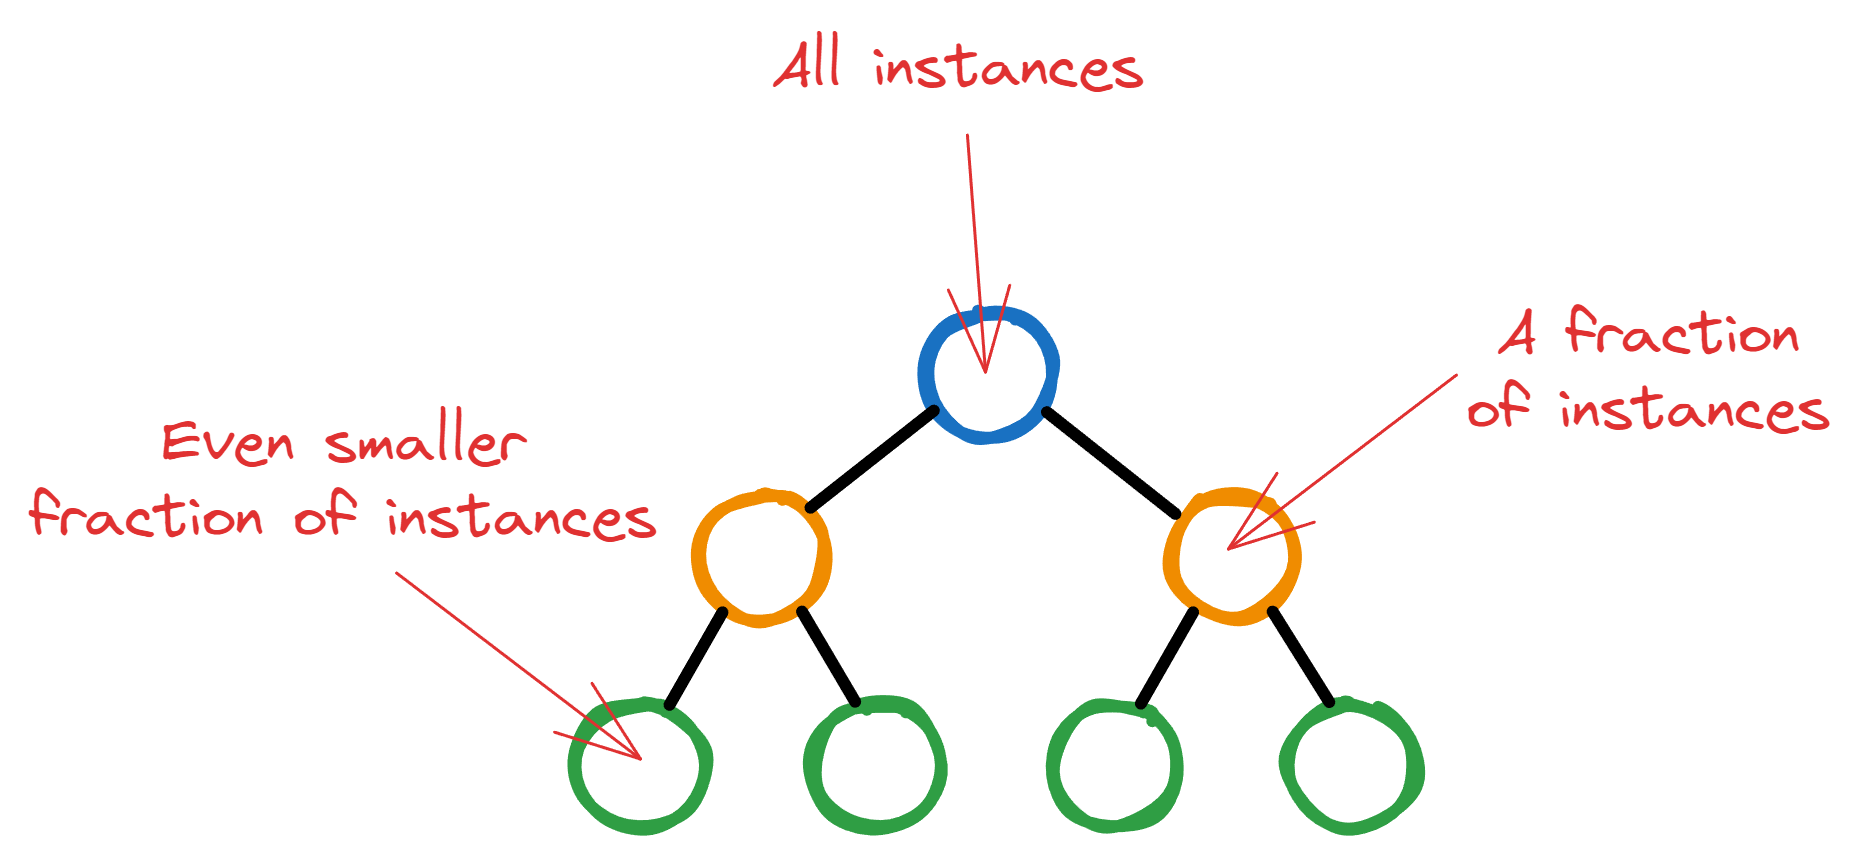

If you let XGBoost run wild, the trees might grow to the point that there is only a few, insignificant instances in the final nodes. That situation is highly undesirable as that is the very definition of overfitting.

That's why XGBoost lets the users to have a threshold for the minimum number of instances in each node to continue splitting. To determine this, all instances in a node are weighted and the sums of the weights are found. Then, if this final weight is smaller than `min_child_weight`, the splitting stops and the node becomes a leaf node.

Even though this explanation is a great oversimplification of the whole process, it should give you the general idea.

----------------

### Conclusion

Even though we've covered a lot of theory, there is still a lot to learn. I suggest giving the following two prompts to ChatGPT:

```
1) Explain the {parameter_name} XGBoost parameter in detail and how to choose values for it wisely.

2) Describe how {parameter_name} fits into the step-by-step tree-building process of XGBoost. 
```

I want to leave a final note saying about you should employ both cross-validation and a pristine final test set for testing model performance after tuning. 

You can split your data 80/20 and tune XGBoost on 80% with 5-7 fold CV and once the best parameters are found, measure the performance one final time on the pristine 20%. This ensures the results you get are as robust as possible.

Don't forget [the GitHub gist code](https://gist.github.com/BexTuychiev/823df08d2e3760538e9b931d38439a68) to use for tuning. Thank you for reading! 

--------------------

Loved this article and, let's face it, its bizarre writing style? Imagine having access to dozens more just like it, all written by a brilliant, charming, witty author (that's me, by the way :).

For only 4.99$ membership, you will get access to not just my stories, but a treasure trove of knowledge from the best and brightest minds on Medium. And if you use [my referral link](https://ibexorigin.medium.com/membership), you will earn my supernova of gratitude and a virtual high-five for supporting my work.

https://ibexorigin.medium.com/membership